# Primal-Dual Algorithm for Image Segmentation

In [49]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
# import pylops
# from pylops import Gradient, BlockDiag
# from pyproximal.optimization.primaldual import *
from pyproximal.optimization.segmentation import *
# from pyproximal import Simplex, L1, L21, VStack
# from pyproximal.optimization.primaldual import PrimalDual
import numba
from numba import cuda
from scripts.bisection_gpu import *
from scripts._Simplex_numba_ import *
from scripts.Segment_gpu import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Example 1: Segmentation of time-lapse difference of subsurface models

In [2]:
# data Loading
m_true = np.load('data/m_true.npy')
m1 = np.load('data/mpd3a.npy')
m2 = np.load('data/mpd3b.npy')
dif = m2 - m1

seg_matrix = np.load('data/seg_matrix.npy')

vmin, vmax =  m1.min(), m1.max()

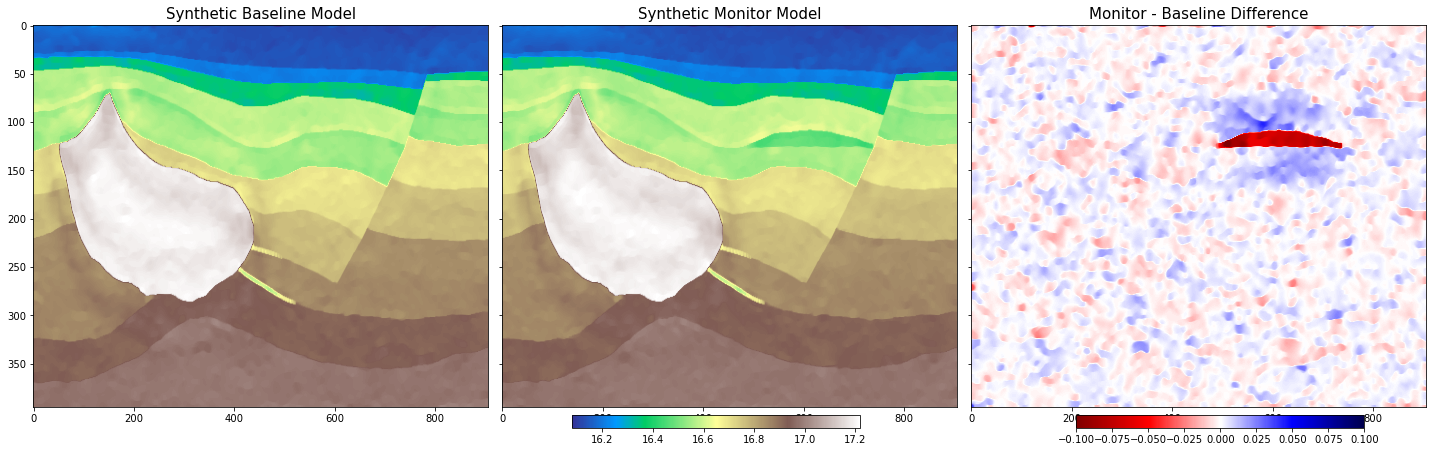

In [3]:
fig, ax = plt.subplots(1,3, figsize=(20,6), sharey=True)
ax = ax.flatten()
ax0 = ax[0].imshow(m1, vmin=vmin,  vmax=vmax, cmap='terrain')
ax[0].set_title('Synthetic Baseline Model', fontsize=15)
ax[0].axis('tight');
ax[1].imshow(m2, vmin=vmin, vmax=vmax, cmap='terrain')
ax[1].set_title('Synthetic Monitor Model', fontsize=15)
ax[1].axis('tight');
ax2=ax[2].imshow(dif, vmin=-0.1, vmax=0.1, cmap='seismic_r')
ax[2].set_title('Monitor - Baseline Difference', fontsize=15)
ax[2].axis('tight');
fig.tight_layout()
fig.subplots_adjust(bottom=0.5)
cbar_ax = fig.add_axes([0.4, 0.001, 0.2, 0.03])
fig.colorbar(ax0, cax=cbar_ax, orientation='horizontal')
fig.subplots_adjust(bottom=0.05)
cbar_ax = fig.add_axes([0.75, 0.001, 0.2, 0.03])
fig.colorbar(ax2, cax=cbar_ax, orientation='horizontal')

Total time: 95.4475519657135sec


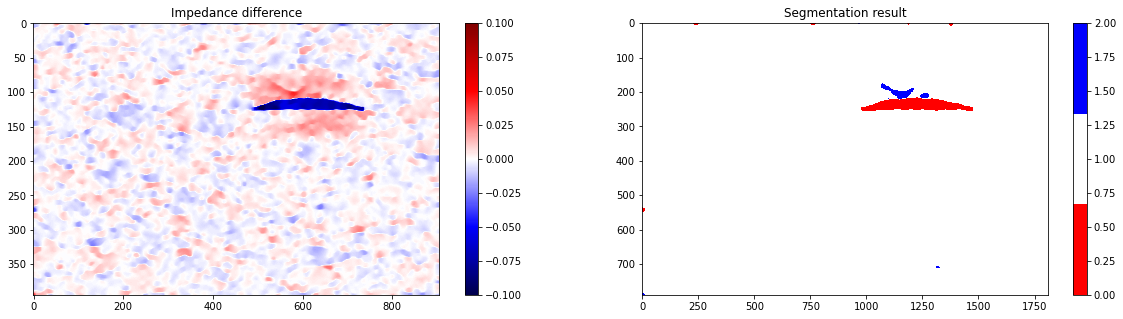

In [47]:
colors = [(1, 0, 0), (142, 142, 142), (0, 0, 1)] 
cmap = LinearSegmentedColormap.from_list('segm', colors, N=3)
cl    = np.array([-0.05,0, 0.05])
sigma = 1.
alpha = 0.001

start = time.time()
segpd, segpd_classes = \
    Segment(dif_2, cl, sigma, alpha, niter=50, show=False, 
            kwargs_simplex=dict(engine='numba', maxiter=10, call=False))
end = time.time()

print(f'Total time: {end - start}sec')

fig, ax = plt.subplots(1,2, figsize=(20,5)) 
im0 = ax[0].imshow(dif, cmap='seismic', vmin = -0.1, vmax = 0.1)
ax[0].axis('tight');
ax[0].set_title('Impedance difference')   
im1 = ax[1].imshow(segpd_classes, cmap=cmap, vmin=0, vmax=2)
ax[1].axis('tight');
ax[1].set_title('Segmentation result') 
fig.colorbar(im0, ax=ax[0], orientation='vertical')
fig.colorbar(im1, ax=ax[1], orientation='vertical')
plt.show()

## Example 2: Segmentation of subsurface model

In [5]:
# allcl = np.unique(m_true)
# nclmin = 3000 #10000
# cl = np.array(list(filter(lambda x: np.count_nonzero(m_true.ravel() == x) > nclmin, allcl)))
# ncl = len(cl)

# segpd, segpd_classes = \
#     Segment(m1, cl, 20., 0.2, niter=50, show=True, 
#             kwargs_simplex=dict(engine='numba',  maxiter=10, call=False))


In [6]:
# fig, ax = plt.subplots(1,2, figsize=(20,5)) 
# ax0 = ax[0].imshow(m1, vmin=vmin,  vmax=vmax, cmap='terrain')
# ax[0].axis('tight');
# ax[0].set_title('Impedance difference')   
# im1 = ax[1].imshow(segpd_classes, cmap='Pastel1', vmin=-0.5, vmax=ncl-0.5,)
# ax[1].axis('tight');
# ax[1].set_title('Segmentation result') 
# fig.colorbar(im0, ax=ax[0], orientation='vertical')
# fig.colorbar(im1, ax=ax[1], orientation='vertical')
# plt.show() 

## Session October 5th

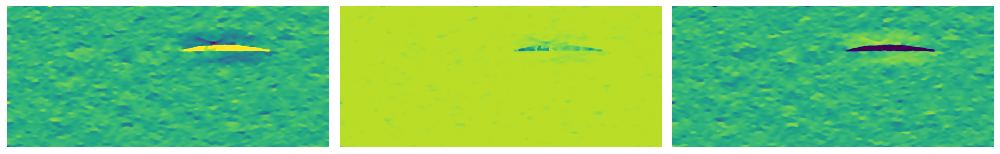

In [3]:
seg_matrix = np.load('data/seg_matrix.npy')

fig, ax = plt.subplots(1,3, figsize=(14,5))
ax[0].imshow(seg_matrix.reshape((3,395,905))[0], vmin=0.325, vmax=0.335)
ax[0].axis('off')
ax[1].imshow(seg_matrix.reshape((3,395,905))[1], vmin=0.325, vmax=0.335)
ax[1].axis('off')
ax[2].imshow(seg_matrix.reshape((3,395,905))[2], vmin=0.325, vmax=0.335)
ax[2].axis('off')
fig.tight_layout()

In [4]:
# x_test = cuda.to_device(np.copy(x))
# y = cuda.device_array_like(x_test)

In [51]:
dims = (395, 905)
ndims = len(dims)
dimsprod = np.prod(np.array(dims))
cl = np.array([-0.05,0, 0.05])
ncl = len(cl)
coeff = np.ones(3)
seg_matrix  = seg_matrix.reshape((ncl, dimsprod))
x = seg_matrix.T

#---------------
n_repeat = 20
x_ = x.reshape((395,905,3)).copy()
x_2 = np.zeros((395*n_repeat, 905*n_repeat, 3))
for i in range(3):
    x_2[:,:,i] = x_[:,:,i].repeat(n_repeat, axis=0).repeat(n_repeat, axis=1)
x_2 = x_2.reshape((395*n_repeat*905*n_repeat, 3))

### Benchmark bisection

Total time: 1.5794909000396729sec


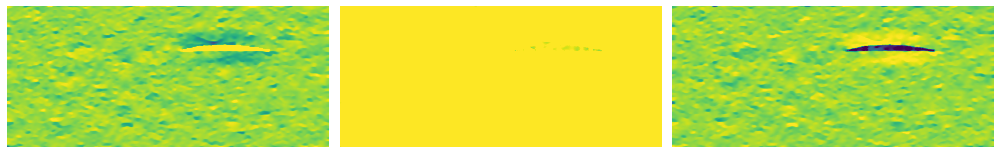

In [52]:
# Benchmark bisection
start = time.time()
v_ = simplex_jit(x, coeff, 1, 0, 10000000000, 10, 1e-8, 1e-8)
end = time.time()

print(f'Total time: {end - start}sec')
v = v_.T
fig, ax = plt.subplots(1,3, figsize=(14,5))
ax[0].imshow(v.reshape((3,395,905))[0], vmin=0.325, vmax=0.335)
ax[0].axis('off')
ax[1].imshow(v.reshape((3,395,905))[1], vmin=0.325, vmax=0.335)
ax[1].axis('off')
ax[2].imshow(v.reshape((3,395,905))[2], vmin=0.325, vmax=0.335)
ax[2].axis('off')
fig.tight_layout()

Loop over different model sizes

Total time for a model of size (25, 25) 1.5685105323791504sec


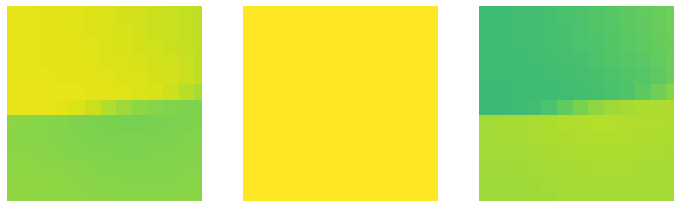

Total time for a model of size (50, 50) 0.0035104751586914062sec


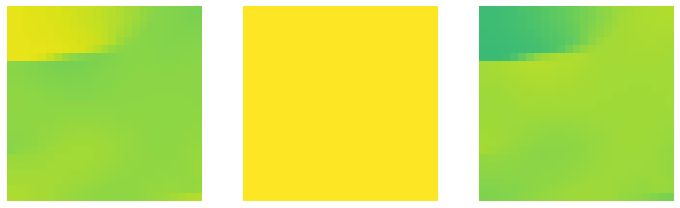

Total time for a model of size (100, 100) 0.012324094772338867sec


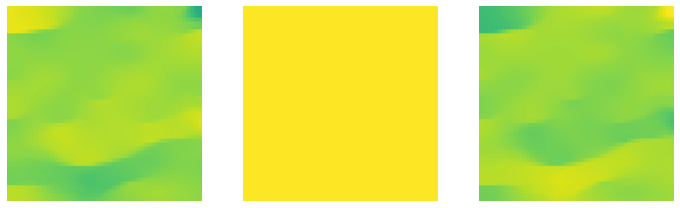

Total time for a model of size (200, 200) 0.04976963996887207sec


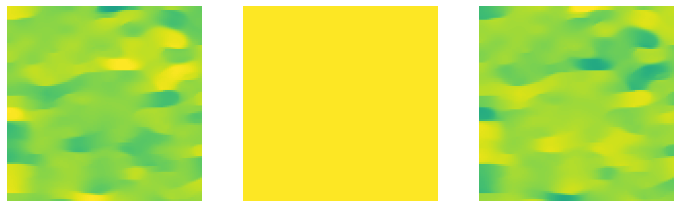

Total time for a model of size (300, 300) 0.11012482643127441sec


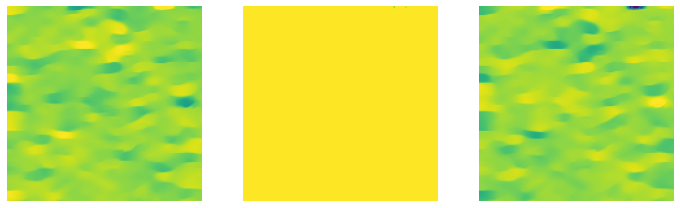

Total time for a model of size (400, 400) 0.19695401191711426sec


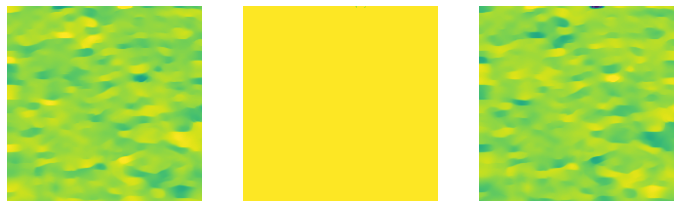

Total time for a model of size (500, 500) 0.3071253299713135sec


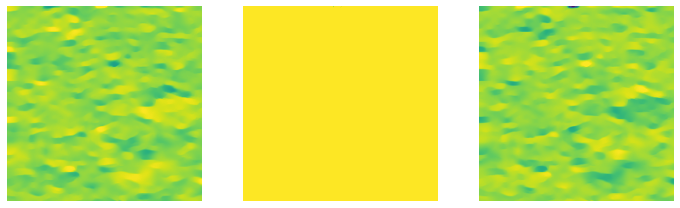

Total time for a model of size (600, 600) 0.44037771224975586sec


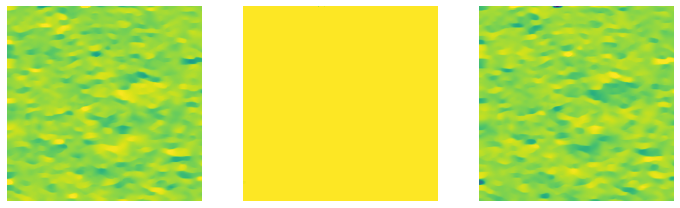

In [5]:
m_time1 = []
model_size = [25, 50, 100, 200, 300, 400, 500, 600]
for i in model_size:
    #Benchmark bisection
    # x_ = x.reshape((395,905,3)).copy()
    x_ = x_2[:i, :i, :]
    x_ = x_.reshape((i*i, 3))
    start = time.time()
    v_ = simplex_jit(x_, coeff, 1, 0, 10000000000, 10, 1e-8, 1e-8)
    end = time.time()
    m_time1.append(end - start)
    
    print(f'Total time for a model of size {i, i} {end - start}sec')
    v = v_.T
    fig, ax = plt.subplots(1,3, figsize=(10,3))
    ax[0].imshow(v.reshape((3,i,i))[0], vmin=0.325, vmax=0.335)
    ax[0].axis('off')
    ax[1].imshow(v.reshape((3,i,i))[1], vmin=0.325, vmax=0.335)
    ax[1].axis('off')
    ax[2].imshow(v.reshape((3,i,i))[2], vmin=0.325, vmax=0.335)
    ax[2].axis('off')
    fig.tight_layout()
    plt.show()

m_time1 = m_time1[1:]
np.save('data/m_time1', m_time1)

### GPU implementation

/sw/csgv/machine_learning/2021.10/el7_cudnn8.2_cuda11.0_py3.8_env/machine_learning-module/env/lib/python3.8/site-packages/numba/cuda/cudadrv/devicearray.py:790: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


Total time: 0.8004190921783447sec


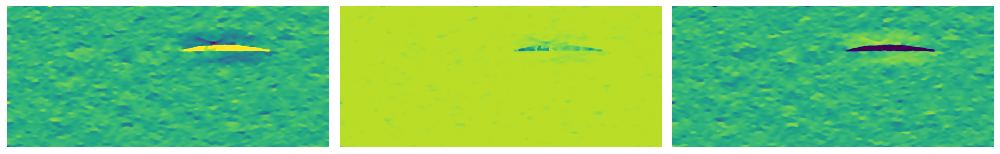

In [54]:
num_threads_per_blocks = 32
num_blocks = (x_2.shape[0] + num_threads_per_blocks - 1) // num_threads_per_blocks
v = np.empty_like(x_2)

start = time.time()
simplex_jit_gpu[num_blocks,num_threads_per_blocks](x, coeff, 1, 0, 10000000000, 10, 1e-8, 1e-8, v)
end = time.time()

print(f'Total time: {end - start}sec')

v_gpu = v.T
fig, ax = plt.subplots(1,3, figsize=(14,5))
ax[0].imshow(seg_matrix.reshape((3,395,905))[0], vmin=0.325, vmax=0.335)
ax[0].axis('off')
ax[1].imshow(seg_matrix.reshape((3,395,905))[1], vmin=0.325, vmax=0.335)
ax[1].axis('off')
ax[2].imshow(seg_matrix.reshape((3,395,905))[2], vmin=0.325, vmax=0.335)
ax[2].axis('off')
fig.tight_layout()

Loop over different model sizes

Total time for a model of size (25, 25) 0.0017883777618408203sec


/sw/csgv/machine_learning/2021.10/el7_cudnn8.2_cuda11.0_py3.8_env/machine_learning-module/env/lib/python3.8/site-packages/numba/cuda/compiler.py:865: NumbaPerformanceWarning: Grid size (20) < 2 * SM count (216) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


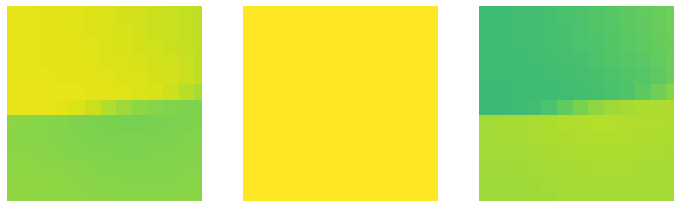

/sw/csgv/machine_learning/2021.10/el7_cudnn8.2_cuda11.0_py3.8_env/machine_learning-module/env/lib/python3.8/site-packages/numba/cuda/compiler.py:865: NumbaPerformanceWarning: Grid size (79) < 2 * SM count (216) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Total time for a model of size (50, 50) 0.0017299652099609375sec


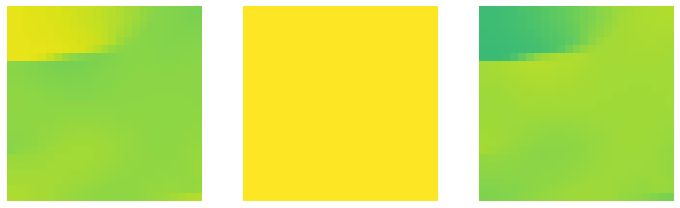

Total time for a model of size (100, 100) 0.0015032291412353516sec


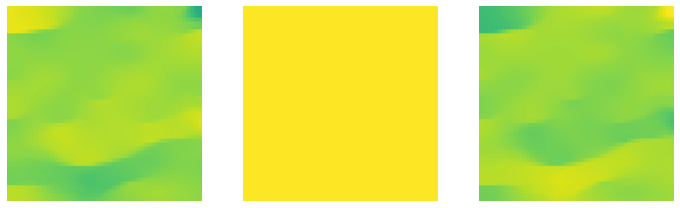

Total time for a model of size (200, 200) 0.0019817352294921875sec


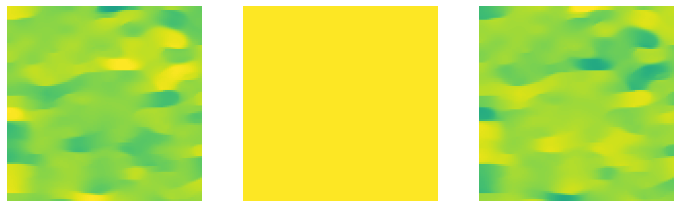

Total time for a model of size (300, 300) 0.003239154815673828sec


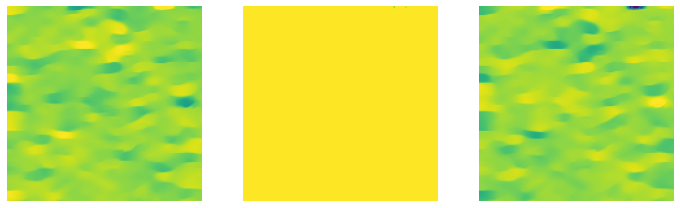

Total time for a model of size (400, 400) 0.00410008430480957sec


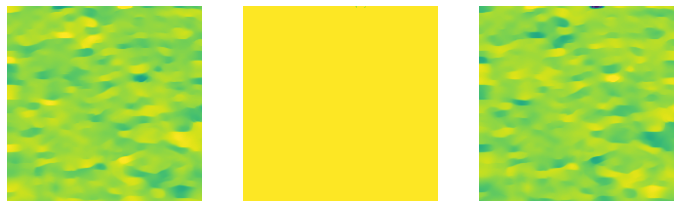

Total time for a model of size (500, 500) 0.005124807357788086sec


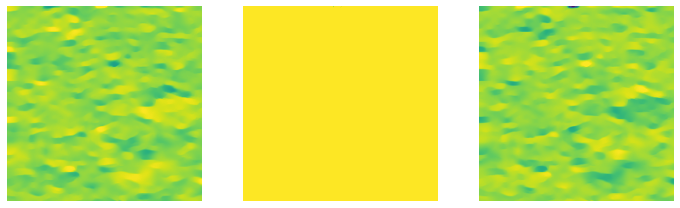

Total time for a model of size (600, 600) 0.005434751510620117sec


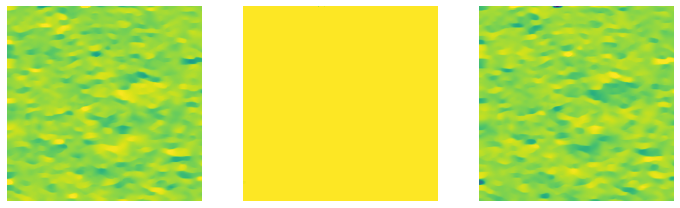

In [5]:
m_time2 = []
model_size = [25, 50, 100, 200, 300, 400, 500, 600]
for i in model_size:
    #Benchmark bisection
    # x_ = x.reshape((395,905,3)).copy()
    x_ = x_2[:i, :i, :]
    x_ = x_.reshape((i*i, 3))
    # print(x_.shape)
    num_threads_per_blocks = 32
    num_blocks = (x_.shape[0] + num_threads_per_blocks - 1) // num_threads_per_blocks
    v = np.empty_like(x_)
    start = time.time()
    # print(x_.shape)
    # print(coeff.shape)
    simplex_jit_gpu[num_blocks,num_threads_per_blocks](x_, coeff, 1, 0, 10000000000, 10, 1e-8, 1e-8, v)
    end = time.time()
    m_time2.append(end - start)
    print(f'Total time for a model of size {i, i} {end - start}sec')
    v = v.T
    fig, ax = plt.subplots(1,3, figsize=(10,3))
    ax[0].imshow(v.reshape((3,i,i))[0], vmin=0.325, vmax=0.335)
    ax[0].axis('off')
    ax[1].imshow(v.reshape((3,i,i))[1], vmin=0.325, vmax=0.335)
    ax[1].axis('off')
    ax[2].imshow(v.reshape((3,i,i))[2], vmin=0.325, vmax=0.335)
    ax[2].axis('off')
    fig.tight_layout()
    plt.show()
    
m_time2 = m_time2[1:]
np.save('data/m_time2', m_time2)

In [35]:
m_time1 = np.append(np.load('data/m_time1.npy'),195.77446341)
m_time2 = np.append(np.load('data/m_time2.npy'), 2.663643121719)
model_size = model_size[1:]

Text(0, 0.5, 'Time [s]')

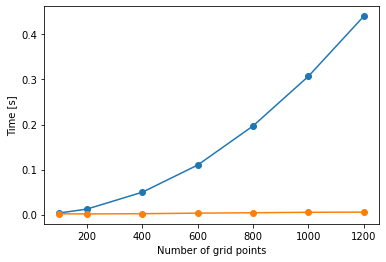

In [44]:
plt.plot(model_size[:-1], m_time1[:-1], '-o');
plt.xlabel('Number of grid points')
plt.plot(model_size[:-1], m_time2[:-1], '-o');
plt.ylabel('Time [s]')

Text(0, 0.5, 'Time [s]')

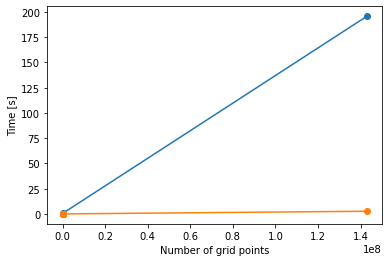

In [45]:
plt.plot(model_size, m_time1, '-o');
plt.xlabel('Number of grid points')
plt.plot(model_size, m_time2, '-o');
plt.ylabel('Time [s]')

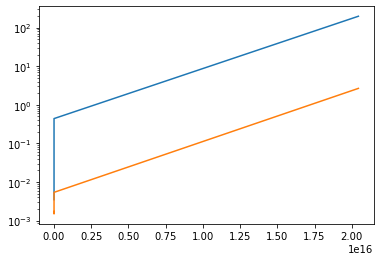

In [30]:
plt.semilogy(np.array(model_size)**2, m_time1)
plt.semilogy(np.array(model_size)**2, m_time2)

Total time: 41.78510522842407sec


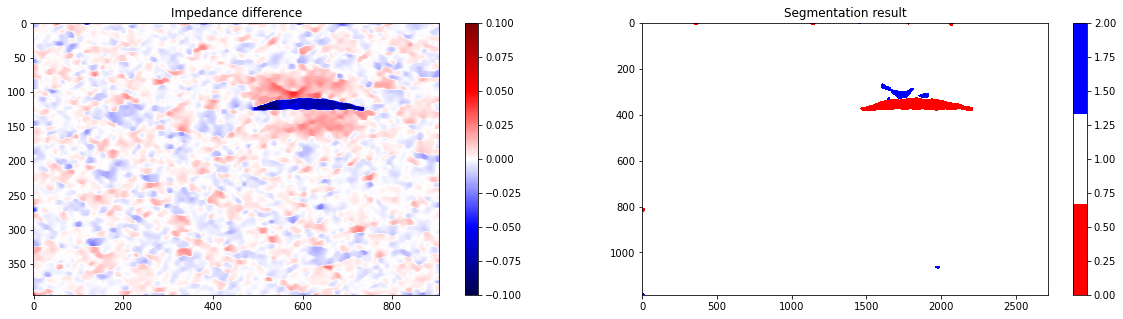

In [26]:
colors = [(1, 0, 0), (142, 142, 142), (0, 0, 1)] 
cmap = LinearSegmentedColormap.from_list('segm', colors, N=3)
cl = np.array([-0.05,0, 0.05])
sigma = 1.
alpha = 0.001

start = time.time()
segpd, segpd_classes = \
    Segment_gpu(dif_2, cl, sigma, alpha, niter=50, show=False, 
            kwargs_simplex=dict(engine='numba', maxiter=10, call=False))
end = time.time()

print(f'Total time: {end - start}sec')

fig, ax = plt.subplots(1,2, figsize=(20,5)) 
im0 = ax[0].imshow(dif, cmap='seismic', vmin = -0.1, vmax = 0.1)
ax[0].axis('tight');
ax[0].set_title('Impedance difference')   
im1 = ax[1].imshow(segpd_classes, cmap=cmap, vmin=0, vmax=2)
ax[1].axis('tight');
ax[1].set_title('Segmentation result') 
fig.colorbar(im0, ax=ax[0], orientation='vertical')
fig.colorbar(im1, ax=ax[1], orientation='vertical')
plt.show() 

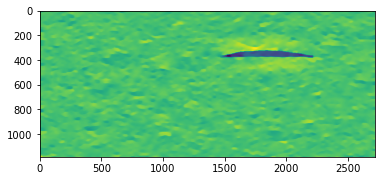

In [11]:
dif_2 = dif.repeat(3, axis=0).repeat(3, axis=1)
plt.imshow(dif_2)

### Experimentation with a simpler examples

In [ ]:
@cuda.jit
def bisection_gpu(x1, x2, c):
    c[0] = x1/abs(x1)

In [ ]:
c = np.zeros(1)
bisection_gpu[1, 1](1, 10, c)

In [ ]:
print(c)

In [ ]:
x_test = cuda.to_device(np.copy(x))
y = cuda.device_array_like(x_test)

In [ ]:
def test_gpu(A):
    B = np.empty_like(A)
    for i in range(A.shape[0]):
        B[i] = A[i] * 2
    return B

In [ ]:
A = np.array(np.random.random(100).reshape((10,10)), dtype=np.float32)
A

In [ ]:
test_gpu(A)

In [ ]:
@cuda.jit(device=True)
def test(x):
    return 2 * x


In [ ]:
@cuda.jit
def sample_kernel(A, B):
    row_idx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
    if row_idx < A.shape[0]:  
        for j in range(A.shape[1]):
#             B[row_idx, j] = 2 * A[row_idx, j]
            
#             dev_c = cuda.device_array((1,), np.float32)
            B[row_idx, j] = test(A[row_idx, j])

In [ ]:
B = np.empty_like(A)
dB = cuda.to_device(B)
dA = cuda.to_device(A)

In [ ]:
num_threads_per_blocks = 32
num_blocks = (A.shape[0] + num_threads_per_blocks - 1) // num_threads_per_blocks
num_threads_per_blocks
num_blocks
sample_kernel[num_blocks,num_threads_per_blocks](dA,dB)

In [ ]:
Bh = dB.copy_to_host()

In [ ]:
Bh

In [15]:
print(np.__version__)
print(numba.__version__)

1.19.5
0.54.1


In [16]:
cuda.detect()

Found 1 CUDA devices
id 0    b'NVIDIA A100-SXM-80GB'                              [SUPPORTED]
                      Compute Capability: 8.0
                           PCI Device ID: 0
                              PCI Bus ID: 70
                                Watchdog: Disabled
             FP32/FP64 Performance Ratio: 2
Summary:
	1/1 devices are supported


True

In [27]:
# Example 1.1: Add scalars
@cuda.jit
def add_scalars(a, b, c):
    c[0] = a + b

dev_c = cuda.device_array((1,), np.float32)
add_scalars[1, 1](2.0, 7.0, dev_c)

c = dev_c.copy_to_host()
print(f"2.0 + 7.0 = {c[0]}")
#  2.0 + 7.0 = 9.0

2.0 + 7.0 = 9.0


/sw/csgv/machine_learning/2021.10/el7_cudnn8.2_cuda11.0_py3.8_env/machine_learning-module/env/lib/python3.8/site-packages/numba/cuda/compiler.py:865: NumbaPerformanceWarning: Grid size (1) < 2 * SM count (216) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


In [8]:
# Example 1.2: Add arrays
@cuda.jit
def add_array(a, b, c):
    i = cuda.threadIdx.x + cuda.blockDim.x * cuda.blockIdx.x
    if i < a.size:
        c[i] = a[i] + b[i]

N = 20000
a = np.arange(N, dtype=np.float32)
b = np.arange(N, dtype=np.float32)
dev_c = cuda.device_array_like(a)

add_array[4, 8](a, b, dev_c)

c = dev_c.copy_to_host()
print(c)

[0. 2. 4. ... 0. 0. 0.]


/sw/csgv/machine_learning/2021.10/el7_cudnn8.2_cuda11.0_py3.8_env/machine_learning-module/env/lib/python3.8/site-packages/numba/cuda/compiler.py:865: NumbaPerformanceWarning: Grid size (4) < 2 * SM count (216) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/sw/csgv/machine_learning/2021.10/el7_cudnn8.2_cuda11.0_py3.8_env/machine_learning-module/env/lib/python3.8/site-packages/numba/cuda/cudadrv/devicearray.py:790: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


In [3]:
dev_a = cuda.to_device(a)
dev_b = cuda.to_device(b)

In [4]:
# Example 1.3: Add arrays with cuda.grid
@cuda.jit
def add_array(a, b, c):
    i = cuda.grid(1)
    if i < a.size:
        c[i] = a[i] + b[i]

add_array[4, 8](dev_a, dev_b, dev_c)

c = dev_c.copy_to_host()
print(c)


[0. 2. 4. ... 0. 0. 0.]


/sw/csgv/machine_learning/2021.10/el7_cudnn8.2_cuda11.0_py3.8_env/machine_learning-module/env/lib/python3.8/site-packages/numba/cuda/compiler.py:865: NumbaPerformanceWarning: Grid size (4) < 2 * SM count (216) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


In [1]:
import torch

In [2]:
print(torch.__version__)
print(torch.cuda.get_device_name(torch.cuda.current_device())); 
print(torch.ones(10).to("cuda:0"))

1.7.1
NVIDIA A100-SXM-80GB
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')


In [3]:
torch.ones(100).to("cuda:0")

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')

In [9]:
threads_per_block = 1024  # Why not!
blocks_per_grid = 32 * 80  # Use 32 * multiple of streaming multiprocessors

# Example 2.1: Naive reduction
@cuda.jit
def reduce_naive(array, partial_reduction):
    i_start = cuda.grid(1)
    threads_per_grid = cuda.blockDim.x * cuda.gridDim.x
    s_thread = 0.0
    for i_arr in range(i_start, array.size, threads_per_grid):
        s_thread += array[i_arr]

    # We need to create a special *shared* array which will be able to be read
    # from and written to by every thread in the block. Each block will have its
    # own shared array. See the warning below!
    s_block = cuda.shared.array((threads_per_block,), numba.float32)
    
    # We now store the local temporary sum of a single the thread into the
    # shared array. Since the shared array is sized
    #     threads_per_block == blockDim.x
    # (1024 in this example), we should index it with `threadIdx.x`.
    tid = cuda.threadIdx.x
    s_block[tid] = s_thread
    
    # The next line synchronizes the threads in a block. It ensures that after
    # that line, all values have been written to `s_block`.
    cuda.syncthreads()

    # Finally, we need to sum the values from all threads to yield a single
    # value per block. We only need one thread for this.
    if tid == 0:
        # We store the sum of the elements of the shared array in its first
        # coordinate
        for i in range(1, threads_per_block):
            s_block[0] += s_block[i]
        # Move this partial sum to the output. Only one thread is writing here.
        partial_reduction[cuda.blockIdx.x] = s_block[0]

In [11]:
from time import perf_counter

In [14]:
N = 1_000_000_000
a = np.arange(N, dtype=np.float32)
a /= a.sum() # a will have sum = 1 (to float32 precision)

s_cpu = a.sum()

# Highly-optimized NumPy CPU code
timing_cpu = np.empty(21)
for i in range(timing_cpu.size):
    tic = perf_counter()
    a.sum()
    toc = perf_counter()
    timing_cpu[i] = toc - tic
timing_cpu *= 1e3  # convert to ms

print(f"Elapsed time CPU: {timing_cpu.mean():.0f} ± {timing_cpu.std():.0f} ms")
# Elapsed time CPU: 354 ± 24 ms

dev_a = cuda.to_device(a)
dev_partial_reduction = cuda.device_array((blocks_per_grid,), dtype=a.dtype)

reduce_naive[blocks_per_grid, threads_per_block](dev_a, dev_partial_reduction)
s = dev_partial_reduction.copy_to_host().sum()  # Final reduction in CPU

np.isclose(s, s_cpu)  # Ensure we have the right number
# True

timing_naive = np.empty(21)
for i in range(timing_naive.size):
    tic = perf_counter()
    reduce_naive[blocks_per_grid, threads_per_block](dev_a, dev_partial_reduction)
    s = dev_partial_reduction.copy_to_host().sum()
    cuda.synchronize()
    toc = perf_counter()
    assert np.isclose(s, s_cpu)    
    timing_naive[i] = toc - tic
timing_naive *= 1e3  # convert to ms

print(f"Elapsed time naive: {timing_naive.mean():.0f} ± {timing_naive.std():.0f} ms")
# Elapsed time naive: 30 ± 12 ms

Elapsed time CPU: 226 ± 0 ms
Elapsed time naive: 7 ± 0 ms
